# **cs:go round winner classification**
the goal of this notebook is to find which team - CT vs T - is most likely to win each round based on team match stats and gear

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **importing & preprocessing the dataset**

### **assigning the dependent and independent variables**:

In [49]:
dataframe = pd.read_csv('/content/drive/MyDrive/TKH/Year 3/Machine Learning/csgo_round_snapshots.csv')
df = pd.DataFrame(dataframe)

df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [50]:
df = df.sample(frac=1).reset_index() # shuffling the dataset

df = df.drop(df.iloc[:, :1], axis=1) # removing the index column created by shuffling
df = df.drop(df.iloc[:, 3:4], axis=1) # removing the map name column
df = df.drop(df.iloc[:, 15:-1], axis=1) # removing the weapon columns

x = df.iloc[:,:-1].values # selecting the independent variable
y = df.iloc[:,-1].values # selecting the dependent variable (round_winner)

df.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner
0,175.00,0.0,5.0,False,500.0,500.0,400.0,468.0,7900.0,30700.0,4.0,5.0,2.0,5.0,5.0,CT
1,54.96,7.0,0.0,False,400.0,452.0,391.0,499.0,20650.0,1950.0,4.0,5.0,3.0,4.0,5.0,T
2,34.02,12.0,7.0,True,300.0,305.0,0.0,358.0,8350.0,3300.0,0.0,4.0,1.0,3.0,4.0,T
3,94.95,1.0,0.0,False,500.0,500.0,500.0,0.0,400.0,8200.0,5.0,0.0,1.0,5.0,5.0,CT
4,93.45,10.0,5.0,False,500.0,500.0,500.0,300.0,750.0,600.0,0.0,0.0,0.0,5.0,5.0,T


### **creating train/test split**

In [51]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=0)

print("xtrain: \n", xtrain)
print("\nxtest: \n", xtest)
print("\nytrain: \n", ytrain)
print("\nytest: \n", ytest)

xtrain: 
 [[54.91 5.0 2.0 ... 2.0 4.0 4.0]
 [54.95 6.0 4.0 ... 0.0 4.0 4.0]
 [174.91 1.0 0.0 ... 0.0 5.0 5.0]
 ...
 [175.0 9.0 6.0 ... 0.0 5.0 5.0]
 [49.89 12.0 9.0 ... 4.0 5.0 2.0]
 [174.95 14.0 9.0 ... 0.0 5.0 5.0]]

xtest: 
 [[6.3 6.0 2.0 ... 1.0 1.0 0.0]
 [109.95 11.0 11.0 ... 1.0 5.0 5.0]
 [114.88 15.0 8.0 ... 3.0 5.0 5.0]
 ...
 [174.91 9.0 1.0 ... 3.0 5.0 5.0]
 [34.95 4.0 5.0 ... 2.0 2.0 1.0]
 [74.95 9.0 2.0 ... 1.0 2.0 5.0]]

ytrain: 
 ['CT' 'T' 'CT' ... 'CT' 'CT' 'T']

ytest: 
 ['CT' 'T' 'CT' ... 'CT' 'CT' 'T']


### **encoding: bomb_planted and round_winner**

In [52]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

print("bomb_planted selection:")
print(xtrain[:,3])
print(xtest[:,3],"\n")

print("round winner selection:")
print(ytrain)
print(ytest,"\n")


# bomb_planted
xtrain[:,3] = encoder.fit_transform(xtrain[:,3])
xtest[:,3] = encoder.transform(xtest[:,3])

# round_winner 
ytrain = encoder.fit_transform(ytrain)
ytest = encoder.transform(ytest)


print("bomb_planted encoding:")
print(xtrain[:,3])
print(xtest[:,3],"\n")

print("round_winner encoding:")
print(ytrain)
print(ytest)

bomb_planted selection:
[False False False ... False False False]
[True False False ... False False False] 

round winner selection:
['CT' 'T' 'CT' ... 'CT' 'CT' 'T']
['CT' 'T' 'CT' ... 'CT' 'CT' 'T'] 

bomb_planted encoding:
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0] 

round_winner encoding:
[0 1 0 ... 0 0 1]
[0 1 0 ... 0 0 1]


### **feature scaling**

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xtrain[:,:3] = scaler.fit_transform(xtrain[:,:3])
xtest[:,:3] = scaler.fit_transform(xtest[:,:3])

xtrain[:,4:15] = scaler.fit_transform(xtrain[:,4:15])
xtest[:,4:15] = scaler.fit_transform(xtest[:,4:15])

## **machine learning models**

### **artificial neural network (ReLU, sigmoid activation)**

In [54]:
modelANN = tf.keras.models.Sequential()

modelANN.add(tf.keras.layers.Dense(units=16, activation="relu"))
modelANN.add(tf.keras.layers.Dense(units=8, activation="relu"))
modelANN.add(tf.keras.layers.Dense(units=4, activation="relu"))
modelANN.add(tf.keras.layers.Dense(units=2, activation="relu"))
modelANN.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [55]:
modelANN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [56]:
xtrainANN = np.asarray(xtrain).astype(np.float32)
ytrainANN = np.asarray(ytrain).astype(np.float32)

xtestANN = np.asarray(xtest).astype(np.float32)
ytestANN = np.asarray(ytest).astype(np.float32)

In [57]:
earlystoppingANN = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=10
                                                    )
historyANN = modelANN.fit(xtrainANN, ytrainANN, batch_size=32, epochs=100, validation_split=0.3, callbacks=[earlystoppingANN])

Epoch 1/100
2009/2009 [==============================] - 7s 3ms/step - loss: 0.5318 - accuracy: 0.7378 - val_loss: 0.4937 - val_accuracy: 0.7477
Epoch 2/100
2009/2009 [==============================] - 8s 4ms/step - loss: 0.4808 - accuracy: 0.7479 - val_loss: 0.4765 - val_accuracy: 0.7492
Epoch 3/100
2009/2009 [==============================] - 8s 4ms/step - loss: 0.4690 - accuracy: 0.7523 - val_loss: 0.4697 - val_accuracy: 0.7502
Epoch 4/100
2009/2009 [==============================] - 6s 3ms/step - loss: 0.4644 - accuracy: 0.7506 - val_loss: 0.4664 - val_accuracy: 0.7479
Epoch 5/100
2009/2009 [==============================] - 6s 3ms/step - loss: 0.4611 - accuracy: 0.7519 - val_loss: 0.4661 - val_accuracy: 0.7490
Epoch 6/100
2009/2009 [==============================] - 6s 3ms/step - loss: 0.4592 - accuracy: 0.7537 - val_loss: 0.4631 - val_accuracy: 0.7487
Epoch 7/100
2009/2009 [==============================] - 7s 4ms/step - loss: 0.4576 - accuracy: 0.7542 - val_loss: 0.4630 - val_ac

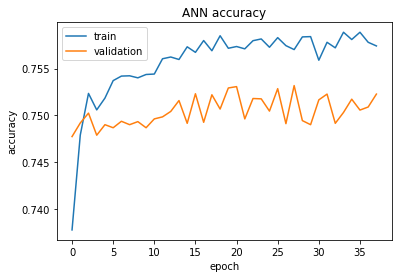

In [58]:
import matplotlib.pyplot as plt

plt.plot(historyANN.history['accuracy'])
plt.plot(historyANN.history['val_accuracy'])

plt.title('ANN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

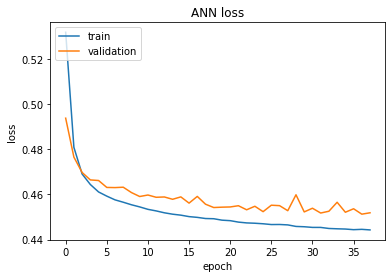

In [59]:
plt.plot(historyANN.history['loss'])
plt.plot(historyANN.history['val_loss'])

plt.title('ANN loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [60]:
modelANN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                256       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


In [61]:
ypredictANN = modelANN.predict(xtestANN)
ypredictANN = (ypredictANN > 0.5)

957/957 [==============================] - 1s 1ms/step


In [62]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracyANN = accuracy_score(ytest, ypredictANN)
recallANN = recall_score(ytest, ypredictANN)
precisionANN = precision_score(ytest, ypredictANN)
f1ANN = f1_score(ytest, ypredictANN)

print("Artificial Neural Network Accuracy:\n", accuracyANN)
print("\nArtificial Neural Network Recall:\n", recallANN)
print("\nArtificial Neural Network Precision:\n", precisionANN)
print("\nArtificial Neural Network F1:\n", f1ANN)

Artificial Neural Network Accuracy:
 0.7488481521419469

Artificial Neural Network Recall:
 0.6985368956743002

Artificial Neural Network Precision:
 0.7884118322802987

Artificial Neural Network F1:
 0.7407582298974636


### **support vector machine**

In [63]:
from sklearn.svm import SVC

classifierSVM = SVC(C=1, gamma=0.05, kernel="linear", random_state=0)
classifierSVM.fit(xtrain, ytrain)

SVC(C=1, gamma=0.05, kernel='linear', random_state=0)

In [64]:
ypredictSVM = classifierSVM.predict(xtest)

In [65]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracySVM = accuracy_score(ytest, ypredictSVM)
recallSVM = recall_score(ytest, ypredictSVM)
precisionSVM = precision_score(ytest, ypredictSVM)
f1SVM = f1_score(ytest, ypredictSVM)

print("Support Vector Machine Accuracy:\n", accuracySVM)
print("\nSupport Vector Machine Recall:\n", recallSVM)
print("\nSupport Vector Machine Precision:\n", precisionSVM)
print("\nSupport Vector Machine F1:\n", f1SVM)

Support Vector Machine Accuracy:
 0.7441427311047937

Support Vector Machine Recall:
 0.7307888040712468

Support Vector Machine Precision:
 0.7615007291528569

Support Vector Machine F1:
 0.7458287346620788


### **random forest**

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators' : [20, 30, 40],
    'max_features' : ['sqrt'],
    'max_depth' : [16, 32, 64],
    'criterion': ['gini', 'entropy'],
    'random_state':[0]
    }

gridSearchRF = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, scoring='accuracy', cv=10, n_jobs=-1)
gridSearchRF.fit(xtrain, ytrain)

rfBestAccuracy = gridSearchRF.best_score_
rfBestParameters = gridSearchRF.best_params_

print("Best Accuracy:", rfBestAccuracy) 
print("Best Parameters:", rfBestParameters)

Best Accuracy: 0.8446305823882276
Best Parameters: {'criterion': 'entropy', 'max_depth': 64, 'max_features': 'sqrt', 'n_estimators': 40, 'random_state': 0}


In [67]:
modelRandomForest = RandomForestClassifier(n_estimators=40, criterion='entropy', max_depth=64, max_features='sqrt', random_state=0)
modelRandomForest.fit(xtrain, ytrain)

RandomForestClassifier(criterion='entropy', max_depth=64, max_features='sqrt',
                       n_estimators=40, random_state=0)

In [68]:
ypredictRandomForest = modelRandomForest.predict(xtest)

In [69]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracyRandomForest = accuracy_score(ytest, ypredictRandomForest)
recallRandomForest = recall_score(ytest, ypredictRandomForest)
precisionRandomForest = precision_score(ytest, ypredictRandomForest)
f1RandomForest = f1_score(ytest, ypredictRandomForest)

print("Random Forest Accuracy:\n", accuracyRandomForest)
print("\nRandom Forest Recall:\n", recallRandomForest)
print("\nRandom Forest Precision:\n", precisionRandomForest)
print("\nRandom Forest F1:\n", f1RandomForest)

Random Forest Accuracy:
 0.8361271770741431

Random Forest Recall:
 0.8239821882951653

Random Forest Precision:
 0.8521149924347082

Random Forest F1:
 0.8378124898935998
